In [40]:
import glob
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import xgboost as xg
import tables as tb
from tqdm import tqdm
from itertools import cycle, islice
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets import make_blobs
from IPython import display
from sklearn.neighbors import BallTree, KDTree, DistanceMetric
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import Normalizer
from keras.layers.core import Dense, Activation, Dropout
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import StratifiedKFold, GridSearchCV, StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import log_loss
from keras.layers.core import Dense, Activation
from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils import np_utils

%matplotlib inline
%pylab inline

# Make the images larger
plt.rcParams['figure.figsize'] = (16, 9)
figsize = (10,10)
point_size=150
point_border=0.8


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['figsize', 'display']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [41]:
train = pd.read_hdf('data/training/open30.h5') # pick just a single brick
test = pd.read_hdf('data/test.h5')

In [42]:
test = test.reset_index(drop=True)

In [43]:
test.head()

,TX,TY,X,Y,Z,data_ind
0,0.087240,0.119438,86536.218750,62988.312500,56892.0,0
1,-0.380208,0.198382,93346.765625,58062.937500,14223.0,0
2,-0.348549,-0.099981,66129.578125,23038.673828,46548.0,0
3,0.585342,-0.126879,68825.523438,55186.625000,45255.0,0
4,0.038579,-0.131510,36366.941406,47564.878906,9051.0,0


In [44]:
train.head()

,TX,TY,X,Y,Z,event_id,signal,data_ind
0,-0.248382,0.072824,37014.070312,38318.898438,31032.0,-999.0,0.0,21
1,0.768548,0.490205,46626.425781,15151.117188,72408.0,188918.0,1.0,21
2,-0.132050,-0.049405,54031.640625,69132.320312,60771.0,-999.0,0.0,21
3,0.260584,0.207106,56653.531250,35025.765625,43962.0,-999.0,0.0,21
4,0.267597,0.111272,42231.714844,47199.027344,20688.0,-999.0,0.0,21


In [45]:
CMAP = sns.diverging_palette(220, 20, s=99, as_cmap=True, n=2500)

def plot3D(X, target, elev=0, azim=0, title=None, sub=111):
    x = X[:, 0]
    y = X[:, 1]
    z = X[:, 2]
    
    fig = plt.figure(figsize=(12, 8))
    ax = Axes3D(fig)
    mappab = ax.scatter(x, y, z, c=target, cmap=CMAP)

    if title is not None:
        ax.set_title(title)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')

# Этот инструмент позволяет менять точку зрения
    ax.view_init(elev=elev, azim=azim)
    fig.colorbar(mappable=mappab, label='Target variable')
    plt.show()
    
feat_XY = ['TX', 'TY', 'X', 'Y']

In [46]:
first = train.loc[train.data_ind == 21, :]

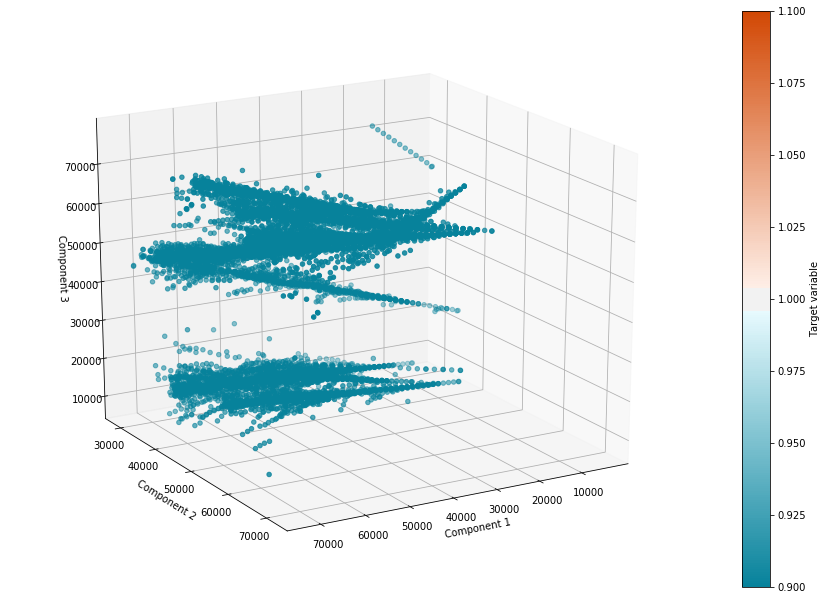

In [47]:
plot3D(first.loc[first.signal==1, ['Z', 'X', 'Y']].values,
       first.loc[first.signal==1].signal.values, elev=20, azim=60)

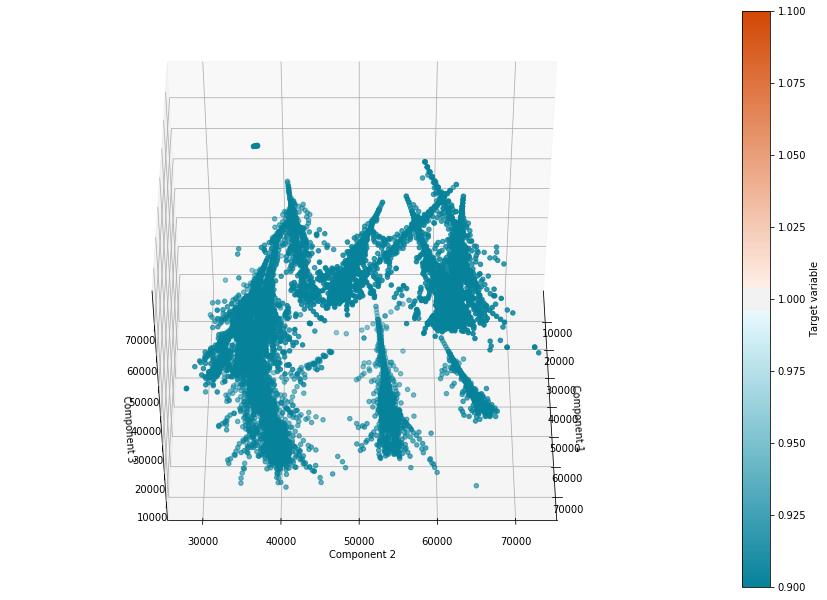

In [48]:
plot3D(first.loc[first.signal==1, ['Z', 'X', 'Y']].values,
       first.loc[first.signal==1].signal.values, elev=45, azim=0)

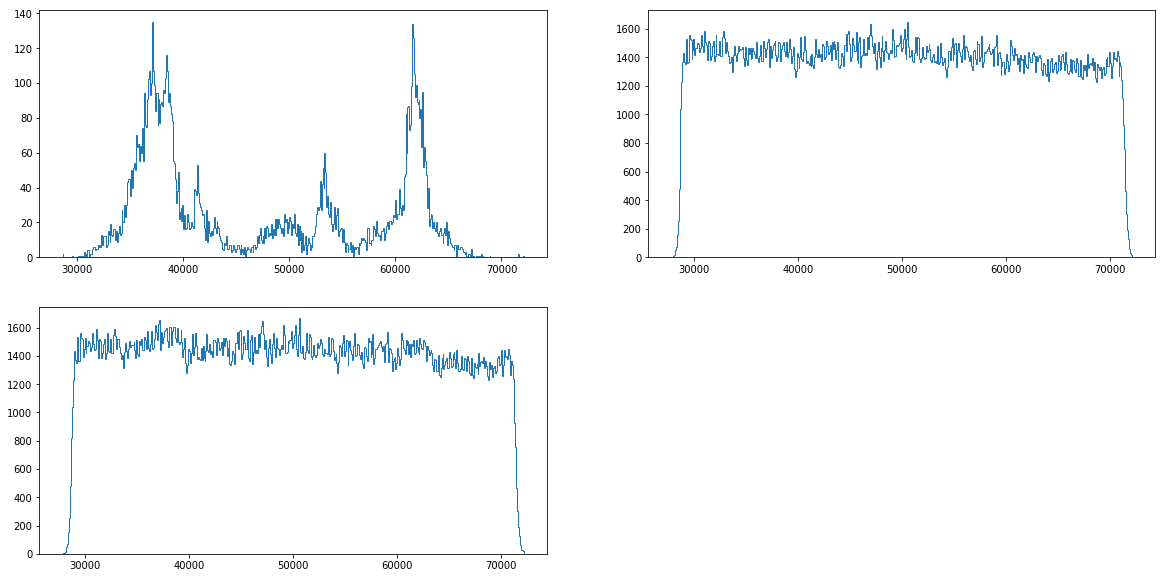

In [49]:
axis = 'X'

fig = plt.figure(figsize = [20, 10])
fig.add_subplot(221)
plt.hist(first.loc[first.signal == 1, axis], bins=500, histtype='step')
fig.add_subplot(222)
plt.hist(first.loc[first.signal == 0, axis], bins=500, histtype='step')
fig.add_subplot(223)
values_X = plt.hist(first.loc[:, axis], bins=500, histtype='step')
plt.show()

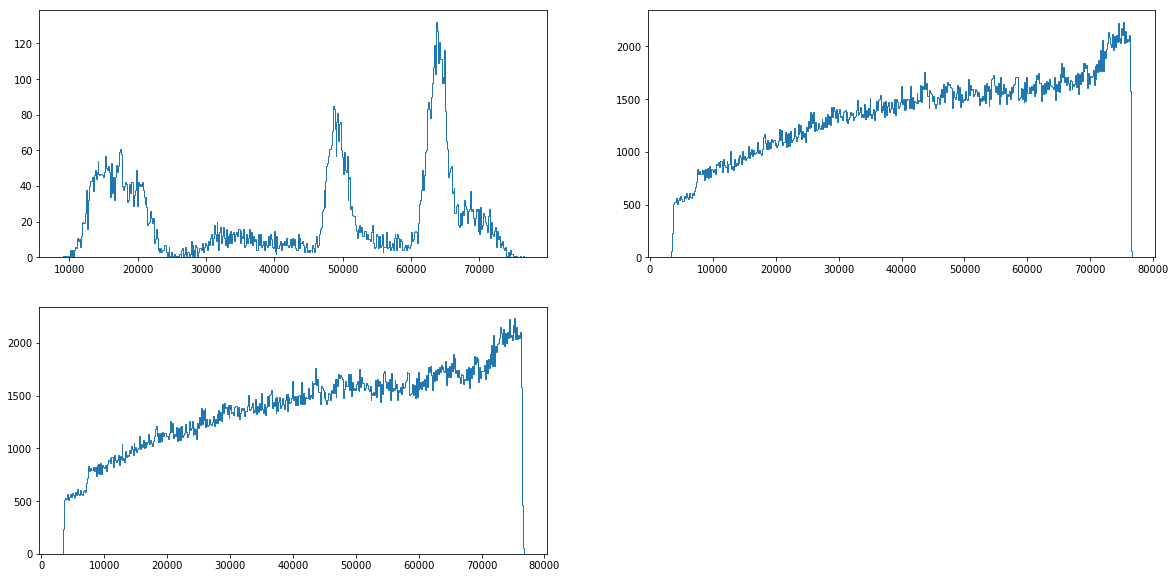

In [50]:
axis = 'Y'

fig = plt.figure(figsize = [20, 10])
fig.add_subplot(221)
plt.hist(first.loc[first.signal == 1, axis], bins=500, histtype='step')
fig.add_subplot(222)
plt.hist(first.loc[first.signal == 0, axis], bins=500, histtype='step')
fig.add_subplot(223)
values_X = plt.hist(first.loc[:, axis], bins=500, histtype='step')
plt.show()

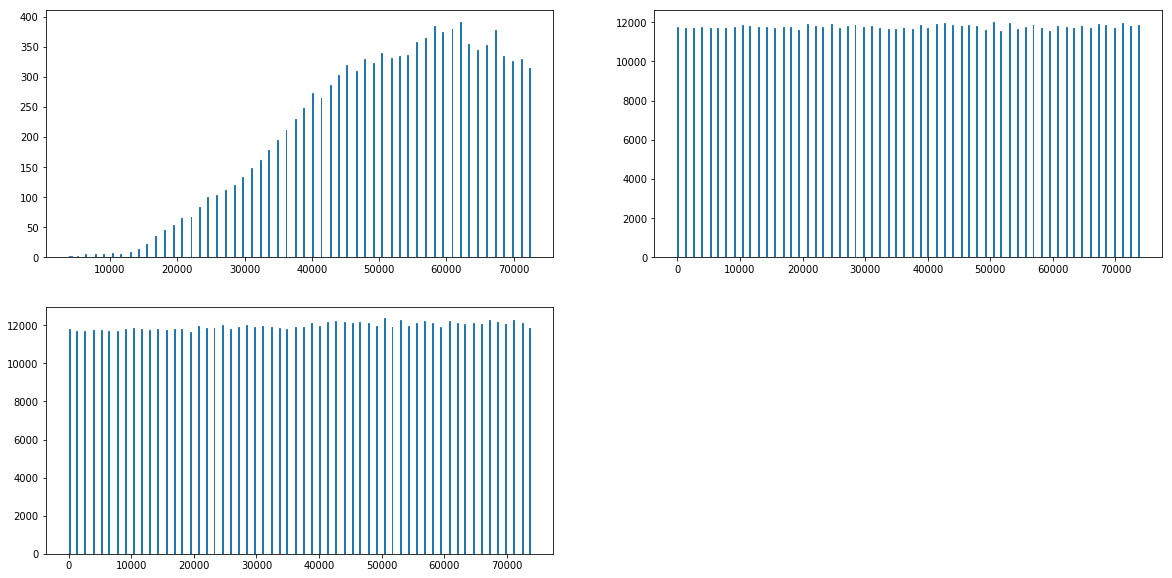

In [51]:
axis = 'Z'

fig = plt.figure(figsize = [20, 10])
fig.add_subplot(221)
plt.hist(first.loc[first.signal == 1, axis], bins=500, histtype='step')
fig.add_subplot(222)
plt.hist(first.loc[first.signal == 0, axis], bins=500, histtype='step')
fig.add_subplot(223)
values_X = plt.hist(first.loc[:, axis], bins=500, histtype='step')
plt.show()

In [52]:
def add_neighbours(df, k, metric='minkowski'):
    res = []
    
    for data_ind in tqdm(np.unique(df.data_ind)):
        ind = df.loc[df.data_ind == data_ind].copy()
        ind[['TX', 'TY']] *= 1293
        values = np.unique(ind.Z)
        
        for j in range(1, len(values)):
            z, z_next = (ind.loc[ind.Z == values[j-1]].copy(),
                         ind.loc[ind.Z == values[j]].copy())
            
            b_tree = BallTree(z_next[feat_XY], metric=metric)
            d, i = b_tree.query(z[feat_XY], k=min(k, len(z_next)))
            
            for m in range(i.shape[1]):
                data = z_next.iloc[i[:, m]]
                z_copy = z.copy()
                for col in feat_XY + ['Z']:
                    z_copy[col + '_pair'] = data[col].values
                res.append(z_copy)
            
        res.append(z_next)
        
    res = pd.concat(res)
    for col in feat_XY + ['Z']:
        res['d' + col] = res[col].values - res[col + '_pair'].values
    return res

def balance_train(df, k):
    data = add_neighbours(df, k=k)
    noise = data.event_id == -999
    signal, not_signal = data.loc[np.logical_not(noise)], data.loc[noise]
    noise_part = not_signal.sample(len(signal))
    return pd.concat([signal, noise_part]).reset_index(drop=True)

train = []

for file in glob.glob('./data/training/open*.h5')[:5]: # just 5 bricks
    train.append(balance_train(pd.read_hdf(file), k=3))
train = pd.concat(train)

100%|██████████| 10/10 [00:30<00:00,  3.09s/it]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

100%|██████████| 10/10 [00:30<00:00,  3.04s/it]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

100%|██████████| 10/10 [00:30<00:00,  3.06s/it]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To acce

In [53]:
y_train = train.signal
X_train = train.drop(['event_id', 'signal', 'data_ind'], axis=1)

In [54]:
transformer = Normalizer()
X_train_norm = transformer.fit_transform(X_train.fillna(0))

In [55]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
train_index, val_index = next(sss.split(X_train_norm, y_train))

## TRAIN MODEL

In [36]:
def nn_model(input_dim):
    model = Sequential()
    model.add(Dense(256, input_dim=input_dim))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=Adam())
    return model


In [37]:
callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto'),
            ModelCheckpoint('{val_loss:.4f}.hdf5', monitor='val_loss', verbose=2, save_best_only=True, mode='auto')]

In [38]:
nn = nn_model(X_train_norm.shape[1])
nn.fit(X_train_norm, y_train, validation_split=0.2, epochs=20, verbose=2, batch_size=256, shuffle=True, callbacks=callbacks)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 3787096 samples, validate on 946774 samples
Epoch 1/20
 - 51s - loss: 0.5777 - val_loss: 0.5683

Epoch 00001: val_loss improved from inf to 0.56833, saving model to 0.5683.hdf5


AttributeError: module 'keras_applications' has no attribute 'set_keras_submodules'

In [39]:
prepared_test = add_neighbours(test, k=3)
X_test = prepared_test.drop(['data_ind'], axis=1)

AttributeError: 'PytestTester' object has no attribute 'data_ind'

In [ ]:
X_test_norm = transformer.transform(X_test.fillna(0))
X_test = transformer.transform(X_test.fillna(0))

In [ ]:
X_test_norm[:5]

In [ ]:
probas = nn.predict_proba(X_test_norm)

In [ ]:
probas = np.squeeze(probas)

In [ ]:
df = pd.DataFrame({'id': prepared_test.index, 'signal': probas}).groupby('id')
agg = df.aggregate(('mean')).loc[:, ['signal']]

In [ ]:
agg.head()

## USE KMEANS TO CLUSTER (DBSCAN)

In [ ]:
train_signal.fillna(0, inplace=True)

In [ ]:
eps=0.000001
min_samples=2
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
clustering_labels = dbscan.fit_predict(train_signal)

In [ ]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(train_signal)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]
k = [inertias.index(i) for i in inertias]

In [ ]:
plt.plot(k, inertias, linewidth=2.0)
line, = plt.plot(k, inertias, 'o')
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)

In [ ]:
#kmeans = KMeans(n_clusters=6, random_state=42).fit(train_signal)
#clustering_labels = kmeans.labels_

In [ ]:
train_signal.shape

In [ ]:
clustering_labels.shape

In [ ]:
clusters = train_signal
clusters['cluster'] = clustering_labels

In [ ]:
X_sample = train_signal.sample(frac=0.1, random_state=42)

In [ ]:
X_sample.head()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_sample.X, X_sample.Y, X_sample.Z, c=X_sample.cluster)

## DL

In [56]:
param_grid = {
        'n_estimators':[10, 20], 
        'max_depth':[15],
}

class XGBClassifier_tmp(XGBClassifier):
    def predict(self, X):
        return XGBClassifier.predict_proba(self, X)[:, 1]

clf = GridSearchCV(XGBClassifier_tmp(learning_rate=0.05, subsample=0.8,
                                     colsample_bytree=0.8, n_jobs=20), 
                   param_grid=param_grid, n_jobs=3,
                   scoring='roc_auc',
                   cv=StratifiedKFold(3, shuffle=True, random_state=0),
                   verbose=7)

In [57]:
clf.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   6 | elapsed:  5.6min remaining: 11.2min
[Parallel(n_jobs=3)]: Done   3 out of   6 | elapsed:  5.6min remaining:  5.6min
[Parallel(n_jobs=3)]: Done   4 out of   6 | elapsed:  5.6min remaining:  2.8min
[Parallel(n_jobs=3)]: Done   6 out of   6 | elapsed:  5.6min remaining:    0.0s


KeyboardInterrupt: 

In [ ]:
clf.best_estimator_

In [ ]:
xgb_class = XGBClassifier_tmp(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         colsample_bytree=0.8, gamma=0, learning_rate=0.05,
         max_delta_step=0, max_depth=15, min_child_weight=1, missing=None,
         n_estimators=100, nthread=None,
         objective='binary:logistic', random_state=0, reg_alpha=0,
         reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
         subsample=0.8, n_jobs=24)

In [ ]:
#preditct
prepared_test = add_neighbours(test, k=3)
X_test = prepared_test.drop(['data_ind'], axis=1)

In [ ]:
xgb_class.fit(X_train, y_train)
probas = xgb_class.predict(X_test)

In [ ]:
df = pd.DataFrame({'id': prepared_test.index, 'signal': probas}).groupby('id')
agg = df.aggregate(('mean')).loc[:, ['signal']]

In [ ]:
agg.shape

In [ ]:
agg.head()

In [ ]:
agg.to_csv('submission.csv.gz', index=True, compression='gzip')

In [ ]:
from sklearn.cluster import DBSCAN
train.fillna(0, inplace=True)
eps=1.32
min_samples=50
dbscan = cluster.DBSCAN(eps=eps, min_samples=min_samples)
clustering_labels = dbscan.fit_predict(train)

def plot_dataset(dataset, xlim=(-15, 15), ylim=(-15, 15)):
    plt.figure(figsize=figsize)
    plt.scatter(dataset[:,0], dataset[:,1], s=point_size, color="#00B3E9", edgecolor='black', lw=point_border)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.show()
    
def plot_clustered_dataset(dataset, y_pred, xlim=(-15, 15), ylim=(-15, 15), neighborhood=False, epsilon=0.5):

    fig, ax = plt.subplots(figsize=figsize)
    
    colors = np.array(list(islice(cycle(['#df8efd', '#78c465', '#ff8e34',
                                     '#f65e97', '#a65628', '#984ea3',
                                     '#999999', '#e41a1c', '#dede00']),
                              int(max(y_pred) + 1))))
    colors = np.append(colors, '#BECBD6')
    
    
    if neighborhood:
        for point in dataset:
            circle1 = plt.Circle(point, epsilon, color='#666666', fill=False, zorder=0, alpha=0.3)
            ax.add_artist(circle1)

    ax.scatter(dataset[:, 0], dataset[:, 1], s=point_size, color=colors[y_pred], zorder=10, edgecolor='black', lw=point_border)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.show()
    
def plot_dbscan_grid(dataset, eps_values, min_samples_values):
    
    fig = plt.figure(figsize=(16, 20))
    plt.subplots_adjust(left=.02, right=.98, bottom=0.001, top=.96, wspace=.05,
                        hspace=0.25)


    plot_num = 1

    for i, min_samples in enumerate(min_samples_values):
        for j, eps in enumerate(eps_values):
            ax = fig.add_subplot( len(min_samples_values) , len(eps_values), plot_num)

            dbscan = cluster.DBSCAN(eps=eps, min_samples=min_samples)
            y_pred_2 = dbscan.fit_predict(dataset)

            colors = np.array(list(islice(cycle(['#df8efd', '#78c465', '#ff8e34',
                                                 '#f65e97', '#a65628', '#984ea3',
                                                 '#999999', '#e41a1c', '#dede00']),
                                          int(max(y_pred_2) + 1))))
            colors = np.append(colors, '#BECBD6')


            for point in dataset:
                circle1 = plt.Circle(point, eps, color='#666666', fill=False, zorder=0, alpha=0.3)
                ax.add_artist(circle1)

            ax.text(0, -0.03, 'Epsilon: {} nMin_samples: {}'.format(eps, min_samples), transform=ax.transAxes, fontsize=16, va='top')
            ax.scatter(dataset[:, 0], dataset[:, 1], s=50, color=colors[y_pred_2], zorder=10, edgecolor='black', lw=0.5)


            plt.xticks(())
            plt.yticks(())
            plt.xlim(-14, 5)
            plt.ylim(-12, 7)

            plot_num = plot_num + 1

    plt.show()
plot_clustered_dataset(train, clustering_labels, 
                              xlim=(-14, 5), 
                              ylim=(-12, 7), 
                              neighborhood=True, 
                              epsilon=0.5)
eps_values = [0.3, 0.5, 1, 1.3, 1.5]
min_samples_values = [2, 5, 10, 20, 80]
plot_dbscan_grid(train, eps_values, min_samples_values)